In [105]:
import tensorflow as tf
import os
import collections
import time
import random
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from glob import glob
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.applications.resnet import preprocess_input

In [106]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299,299))
    img = preprocess_input(img)

    return img, image_path

In [107]:
image_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
image_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(image_input, hidden_layer)

In [108]:
with open("../dataset/captions.json") as jf:
    captions = json.loads(jf.read())

#Extract lstm from captions data set.
lstm_info = captions.pop("lstm_labels")
lstm_ranker = lstm_info['labels']
max_vocab_size = lstm_info['vocab_size']
max_caption_size = lstm_info['longest_caption']

#Dataset cleanup
img_name_vector = []
edited_captions = []

image_paths = list(captions.keys())
random.shuffle(image_paths)

for image_path in image_paths:
    captions_image = captions[image_path]
    captions_len = len(captions_image)

    seed = random.randint(0, captions_len-1)

    img_name_vector.append(image_path)
    edited_captions.append(f"<start> {captions_image[seed]} <end>")

# for image_path in image_paths:
#     captions_image = captions[image_path]
#     captions_len = len(captions_image)
    
#     for c in captions_image:
#         caption = f"<start> {c} <end>"
#         edited_captions.append(caption)
    
#     img_name_vector.extend([f"{image_path}.jpg"] * captions_len)

# train_set_size = round(len(img_name_vector) * 0.9)
# test_set_size = len(img_name_vector) - train_set_size

# while(img_name_vector[train_set_size] != img_name_vector[train_set_size + 1]):
#     train_set_size += 1
#     test_set_size -= 1

# print(f"TRAIN SET SIZE: {train_set_size}.")
# print(f"TEST SET SIZE: {test_set_size}.")

# train_captions = edited_captions[:train_set_size]
# train_image_name = img_name_vector[:train_set_size]
# test_captions = edited_captions[train_set_size:]
# test_image_name = img_name_vector[train_set_size:]
# for i in range(len(img_name_vector)):
#     img_name_vector[i] = f"../dataset/prep_data/{img_name_vector[i]}"

<start> He is smiling. <end>


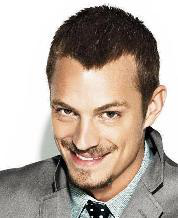

In [109]:
print(edited_captions[20])
Image.open(f"../dataset/prep_data/{img_name_vector[20]}.jpg")

In [110]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))
    
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

0it [00:00, ?it/s]


NotFoundError: 1; No such file or directory
	 [[{{node ReadFile}}]]

In [111]:
# train_set_size = 15000
# test_set_size = 2000

# while train_image_name[train_set_size] == train_image_name[train_set_size + 1]:
#     train_set_size += 1

# train_images = train_image_name[:train_set_size]
# temp = train_captions[:train_set_size]

# index_end = train_set_size + test_set_size

# while train_image_name[index_end] == train_image_name[index_end+1]:
#     index_end +=1
    
# test_images = train_image_name[train_set_size:index_end]
# test_captions = train_captions[train_set_size:index_end]
# train_captions = temp

In [112]:
# print(len(test_images))
# print(len(test_captions))
# print(len(train_images))
# print(len(train_captions))

In [113]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [114]:
top_v = 45

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_v,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(edited_captions)

In [115]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [116]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(edited_captions)

In [117]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [118]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [119]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt])
  cap_train.append(img_to_cap_vector[imgt][0])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv])
  cap_val.append(img_to_cap_vector[imgv][0])

In [120]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)
    

(8141, 8141, 2036, 2036)

In [121]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 512
units = 512
vocab_size = top_v + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 100

In [122]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load('../dataset/prep_data/'+img_name.decode('utf-8')+'.jpg.npy')
  return img_tensor, cap

In [123]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]))

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [124]:
from gru_decoder import GRU_Decoder
from cnn_encoder import CNN_Encoder
from gru_encoder import GRU_Encoder

In [125]:
decoder = GRU_Decoder(embedding_dim, units, vocab_size)
encoder = CNN_Encoder(embedding_dim)
enc = GRU_Encoder(embedding_dim, units, vocab_size)

In [126]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [127]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [128]:
# start_epoch = 0
# if ckpt_manager.latest_checkpoint:
#   start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#   # restoring the latest checkpoint in checkpoint_path
ckpt.restore(ckpt_manager.latest_checkpoint)

In [129]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [130]:
import sys
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])
  hidden_e = enc.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
  m=dec_input
  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
  
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          
          loss += loss_function(target[:,i], predictions)
          # loss += loss_function(target[:, i], predictions)

          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [131]:
print(tokenizer.word_index)

{'<unk>': 1, '<start>': 2, '<end>': 3, 'she': 4, 'has': 5, 'is': 6, 'he': 7, 'hair': 8, 'a': 9, 'younger': 10, 'wearing': 11, 'smiling': 12, 'nose': 13, 'big': 14, 'lipstick': 15, 'an': 16, 'oval': 17, 'face': 18, 'older': 19, 'wavy': 20, 'black': 21, 'pointy': 22, 'brown': 23, 'straight': 24, 'lips': 25, 'beard': 26, 'bangs': 27, 'earings': 28, 'blond': 29, 'necklace': 30, 'necktie': 31, 'receding': 32, 'hairline': 33, 'eyeglasses': 34, 'hat': 35, 'gray': 36, 'sideburns': 37, 'goatee': 38, 'chubby': 39, 'pale': 40, 'skin': 41, 'double': 42, 'chin': 43, 'mustache': 44, 'rosy': 45, 'cheeks': 46, 'bald': 47, '<pad>': 0}


In [132]:
EPOCHS = 15

for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):

        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.5541
Epoch 1 Batch 100 Loss 0.3901
Epoch 1 Batch 200 Loss 0.4198
Epoch 1 Loss 0.513676
Time taken for 1 epoch 73.27491188049316 sec

Epoch 2 Batch 0 Loss 0.3468
Epoch 2 Batch 100 Loss 0.3616
Epoch 2 Batch 200 Loss 0.3431
Epoch 2 Loss 0.362351
Time taken for 1 epoch 62.9020631313324 sec

Epoch 3 Batch 0 Loss 0.3135
Epoch 3 Batch 100 Loss 0.3469
Epoch 3 Batch 200 Loss 0.3157
Epoch 3 Loss 0.328740
Time taken for 1 epoch 63.375600814819336 sec

Epoch 4 Batch 0 Loss 0.2736
Epoch 4 Batch 100 Loss 0.2493
Epoch 4 Batch 200 Loss 0.2356
Epoch 4 Loss 0.282036
Time taken for 1 epoch 64.777841091156 sec

Epoch 5 Batch 0 Loss 0.2683
Epoch 5 Batch 100 Loss 0.2296
Epoch 5 Batch 200 Loss 0.2215
Epoch 5 Loss 0.217558
Time taken for 1 epoch 68.8906602859497 sec

Epoch 6 Batch 0 Loss 0.1580
Epoch 6 Batch 100 Loss 0.1549
Epoch 6 Batch 200 Loss 0.1218
Epoch 6 Loss 0.146656
Time taken for 1 epoch 66.32937908172607 sec

Epoch 7 Batch 0 Loss 0.1459
Epoch 7 Batch 100 Loss 0.0808
Epoch 7 B

In [143]:
from prep import Preparation

prep = Preparation()

with open("../dataset/best_captions.json", "r") as jf:
    data = json.loads(jf.read())

target_data = data['target_paths']
distractor_data = data['distractor_paths']
caption_data = data['best_captions']

edited_caption_data = []
for i in range(len(caption_data)):
    edited_caption_data.append(f'<start> {caption_data[i]} <end>')

#Split into train, val, and test set.
val_slice_index = int(len(target_data)*0.8)
test_slice_index = int(len(target_data)*0.9)

targ_name_train, targ_name_val, targ_name_test = target_data[:val_slice_index], target_data[val_slice_index:test_slice_index], target_data[test_slice_index:]

dis_name_train, dis_name_val, dis_name_test = distractor_data[:val_slice_index], distractor_data[val_slice_index:test_slice_index], distractor_data[test_slice_index:]

captions_train, captions_val, captions_test = edited_caption_data[:val_slice_index], edited_caption_data[val_slice_index:test_slice_index], edited_caption_data[test_slice_index:]

#Tokenize the captions
top_v = 45

tokenizer_2 = tf.keras.preprocessing.text.Tokenizer(num_words=top_v,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer_2.fit_on_texts(captions_train)
tokenizer_2.word_index['<pad>'] = 0
tokenizer_2.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer_2.texts_to_sequences(captions_train)


# Create the tokenized vectors
train_seqs = tokenizer_2.texts_to_sequences(captions_train)

cap_vector_2 = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

l_dataset = tf.data.Dataset.from_tensor_slices((targ_name_train, dis_name_train, cap_vector_2))

# Use map to load the numpy files in parallel
l_dataset = l_dataset.map(lambda item1, item2, item3: tf.numpy_function(
          prep.map_func_oracle, [item1, item2, item3], [tf.float32, tf.float32, tf.int32]))

# Shuffle and batch
l_dataset = l_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

gru_encoder_l = GRU_Encoder(embedding_dim, units, vocab_size)
encoder_l = CNN_Encoder(embedding_dim)

optimizer_l = tf.keras.optimizers.Adam()
loss_object_l = tf.keras.losses.CategoricalCrossentropy()

# @tf.function
def train_step(m, targ, dist):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = gru_encoder_l.reset_state(batch_size=targ.shape[0])

    with tf.GradientTape() as tape:
        #could be a serious problem -- most likely! Exciting
        features_t = encoder_l(targ)
        features_d = encoder_l(dist)

        v = gru_encoder_l(m, hidden)
        
        with tape.stop_recording():
            rand_n = random.random()

            if rand_n > 0.5:
                left = features_t
                right = features_d
                y_t = tf.convert_to_tensor([[1,0]]*targ.shape[0],dtype=tf.float32)
            else:
                left = features_d
                right = features_t
                y_t = tf.convert_to_tensor([[0,1]]*targ.shape[0],dtype=tf.float32)
    
        x = tf.norm(tf.keras.layers.dot([left, v],axes=2,normalize=True),axis=(1,2))
        y = tf.norm(tf.keras.layers.dot([right, v],axes=2,normalize=True),axis=(1,2))
        x = tf.reshape(x, (x.shape[0],1))
        y = tf.reshape(y, (y.shape[0],1))
        z = tf.concat([x,y],axis=1)
        y_p = tf.nn.softmax(z)
        loss = loss_object_l(y_t, y_p)

    trainable_variables = encoder_l.trainable_variables + gru_encoder_l.trainable_variables
    
    gradients = tape.gradient(loss, trainable_variables)
    optimizer_l.apply_gradients(zip(gradients, trainable_variables))

    return loss

EPOCHS = 20

for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (targ_tensor, dis_tensor, target)) in enumerate(l_dataset):
        target = tf.one_hot(target, vocab_size)
        loss = train_step(target, targ_tensor, dis_tensor)
        total_loss += loss
        
        if batch % 100 == 0:
          print ('Epoch {} Batch {} Loss {:.4f}'.format(
            epoch + 1, batch, loss.numpy()))
              
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()
      
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.7021
Epoch 1 Batch 100 Loss 0.4221
Epoch 1 Batch 200 Loss 0.1394
Epoch 1 Batch 300 Loss 0.2903
Epoch 1 Batch 400 Loss 0.1772
Epoch 1 Batch 500 Loss 0.2122
Epoch 1 Loss 0.561628
Time taken for 1 epoch 114.3363528251648 sec

Epoch 2 Batch 0 Loss 0.3012
Epoch 2 Batch 100 Loss 0.1588
Epoch 2 Batch 200 Loss 0.0894
Epoch 2 Batch 300 Loss 0.1120
Epoch 2 Batch 400 Loss 0.1218
Epoch 2 Batch 500 Loss 0.1111
Epoch 2 Loss 0.278617
Time taken for 1 epoch 122.6809778213501 sec

Epoch 3 Batch 0 Loss 0.1464
Epoch 3 Batch 100 Loss 0.1616
Epoch 3 Batch 200 Loss 0.1089
Epoch 3 Batch 300 Loss 0.0652
Epoch 3 Batch 400 Loss 0.0702
Epoch 3 Batch 500 Loss 0.1215
Epoch 3 Loss 0.172870
Time taken for 1 epoch 123.7355887889862 sec

Epoch 4 Batch 0 Loss 0.2721
Epoch 4 Batch 100 Loss 0.0518
Epoch 4 Batch 200 Loss 0.0492
Epoch 4 Batch 300 Loss 0.0449
Epoch 4 Batch 400 Loss 0.0794
Epoch 4 Batch 500 Loss 0.0389
Epoch 4 Loss 0.115585
Time taken for 1 epoch 122.00450205802917 sec

Epoch 5 Batch 0

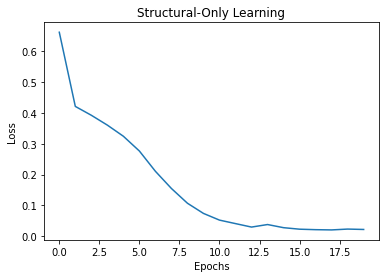

In [253]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Structural-Only Learning")
plt.show()

In [27]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [28]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()



Prediction Caption: he is younger <end>


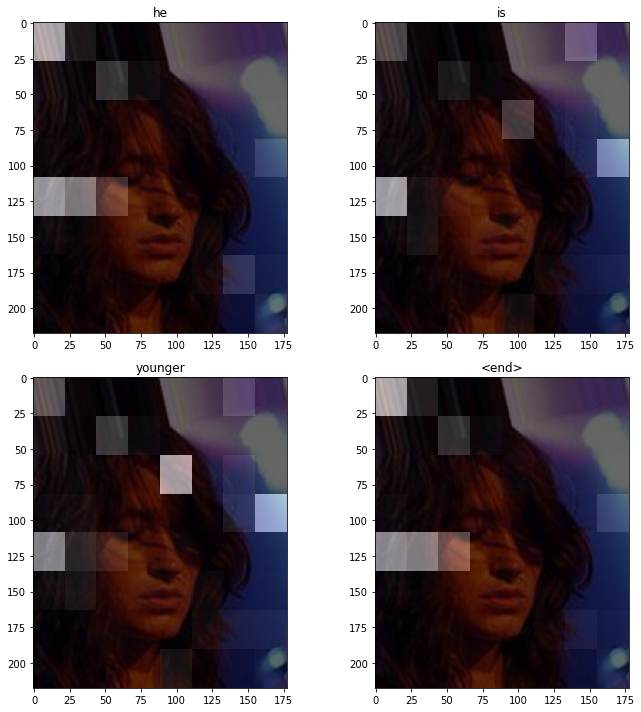

In [133]:
result, attention_plot = evaluate(f"../dataset/prep_data/{img_name_train[768]}.jpg")
print ('Prediction Caption:', ' '.join(result))
real_cap = cap_train[768]
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{img_name_train[768]}.jpg")
plot_attention(f"../dataset/prep_data/{img_name_train[768]}.jpg", result, attention_plot)

Prediction Caption: he has a big nose <end>


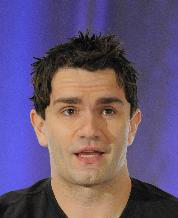

In [158]:
result, attention_plot = evaluate(f"../dataset/prep_data/{img_name_vector[900]}.jpg")
print ('Prediction Caption:', ' '.join(result))
Image.open(f"../dataset/prep_data/{img_name_vector[900]}.jpg")


In [135]:
plot_attention(f"../dataset/prep_data/{img_name_vector[900]}.jpg", result[:-1], attention_plot)


ValueError: num must be 1 <= num <= 4, not 5

Prediction Caption: he has black hair <end>


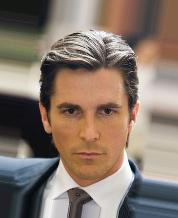

In [157]:
result, attention_plot = evaluate(f"../dataset/prep_data/{img_name_vector[1652]}.jpg")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{img_name_vector[1652]}.jpg")

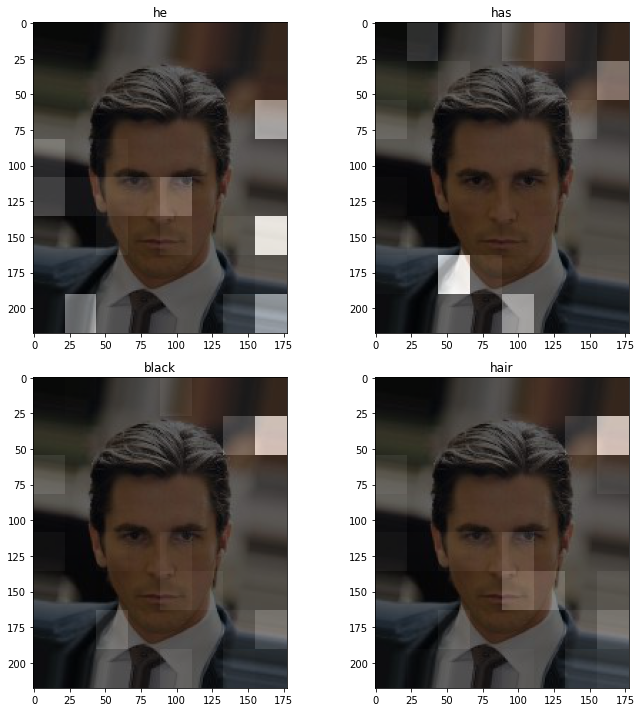

In [137]:
plot_attention(f"../dataset/prep_data/{img_name_vector[1652]}.jpg", result[:-1], attention_plot)


Prediction Caption: she has black hair <end>


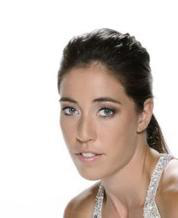

In [156]:
result, attention_plot = evaluate(f"../dataset/prep_data/{img_name_train[43]}.jpg")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{img_name_train[43]}.jpg")

Prediction Caption: she is younger <end>


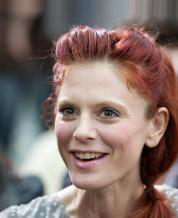

In [155]:
result, attention_plot = evaluate(f"../dataset/prep_data/{img_name_val[1022][0]}.jpg")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{img_name_val[1022][0]}.jpg")

In [140]:
result, attention_plot = evaluate(f"../dataset/prep_data/{train_image_name[78]}")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/prep_data/{train_image_name[78]}")

NameError: name 'train_image_name' is not defined

Prediction Caption: he is smiling <end>


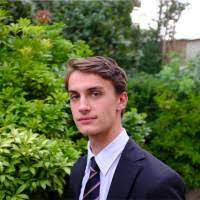

In [141]:
result, attention_plot = evaluate(f"../dataset/custom/dewerpe.jpg")
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)      
# opening the image
Image.open(f"../dataset/custom/dewerpe.jpg")

In [146]:
with open("../dataset/best_captions.json", "r") as jf:
    data = json.loads(jf.read())

target_data = data['target_paths']
distractor_data = data['distractor_paths']

caption_data = data['best_captions']

In [147]:
# Load the numpy files
def map_func_test(img_name, img_name_2):
  img_tensor = np.load('../dataset/prep_data/'+img_name.decode('utf-8')+'.jpg.npy')
  img_tensor_2 = np.load('../dataset/prep_data/'+img_name_2.decode('utf-8')+'.jpg.npy')

  return img_tensor, img_tensor_2

In [148]:
#Split into train, val, and test set.
val_slice_index = int(len(target_data)*0.8)
test_slice_index = int(len(target_data)*0.9)

targ_name_train, targ_name_val, targ_name_test = target_data[:val_slice_index], target_data[val_slice_index:test_slice_index], target_data[test_slice_index:]

dis_name_train, dis_name_val, dis_name_test = distractor_data[:val_slice_index], distractor_data[val_slice_index:test_slice_index], distractor_data[test_slice_index:]

In [149]:
testset = tf.data.Dataset.from_tensor_slices((targ_name_train, dis_name_train))

# Use map to load the numpy files in parallel
testset = testset.map(lambda item1, item2: tf.numpy_function(
          map_func_test, [item1, item2], [tf.float32, tf.float32]))

# Shuffle and batch
testset = testset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [150]:
def check_understanding_captioning(data):
    total_right = 0
    total_wrong = 0

    for (batch, (targ_tensor, dis_tensor)) in enumerate(data):
        hidden_s = decoder.reset_state(batch_size=targ_tensor.shape[0])
        hidden_l = gru_encoder_l.reset_state(batch_size=targ_tensor.shape[0])

        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * targ_tensor.shape[0], 1)

        m = dec_input

        #Encode the image through CNN
        features = encoder(targ_tensor)

        for i in range(1,max_length):
            predictions, hidden, _ = decoder(dec_input, features, hidden_s)
            
            preds = tf.nn.softmax(predictions)
            indices = tf.math.argmax(predictions, axis=1)
            indices = tf.reshape(tf.cast(indices, tf.int32),(targ_tensor.shape[0],1))
            
            m = tf.concat([m, indices],1)

            dec_input = indices

        m = tf.one_hot(m, vocab_size)

        features_t = encoder_l(targ_tensor)
        features_d = encoder_l(dis_tensor)

        rand_n = random.random()

        left = features_t
        right = features_d

        v = gru_encoder_l(m, hidden_l)

        x = tf.norm(tf.keras.layers.dot([left, v],axes=2,normalize=True),axis=(1,2))
        y = tf.norm(tf.keras.layers.dot([right, v],axes=2,normalize=True),axis=(1,2))

        mask = tf.math.greater(x, y)
        total_right += np.sum(mask.numpy())
        total_wrong += np.sum(mask.numpy()==False)

    total = total_right + total_wrong

    acc = total_right / total

    return acc, total_right, total_wrong

In [93]:
acc, t_r, t_w = check_understanding_captioning(testset)
print(acc, t_r, t_w) 

0.46090909090909093 1014 1186


In [151]:
def map_func_test(img_name, img_name_2):
  img_tensor = np.load('../dataset/prep_data/'+img_name.decode('utf-8')+'.jpg.npy')
  img_tensor_2 = np.load('../dataset/prep_data/'+img_name_2.decode('utf-8')+'.jpg.npy')

  return img_tensor, img_tensor_2

In [159]:
with open("../dataset/best_captions.json", "r") as jfec:
    data = json.loads(jfec.read())

target_data = data['target_paths']
distractor_data = data['distractor_paths']

val_slice_index = int(len(target_data)*0.8)
test_slice_index = int(len(target_data)*0.9)

targ_test = target_data[:test_slice_index]

dis_test = distractor_data[:test_slice_index]

testset = tf.data.Dataset.from_tensor_slices((targ_test, dis_test))
testset = testset.map(lambda item1, item2: tf.numpy_function(
          map_func_test, [item1, item2], [tf.float32, tf.float32]))

testset = testset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

with open("../dataset/easy_captions.json", "r") as jfec:
    easy_data = json.loads(jfec.read())

target_easy_data = easy_data['target_paths']
distractor_easy_data = easy_data['distractor_paths']

val_slice_index = int(len(target_easy_data)*0.8)
test_slice_index = int(len(target_easy_data)*0.9)

targ_easy_test = target_easy_data[:test_slice_index]

dis_easy_test = distractor_easy_data[:test_slice_index]

testset_easy = tf.data.Dataset.from_tensor_slices((targ_easy_test, dis_easy_test))
testset_easy = testset_easy.map(lambda item1, item2: tf.numpy_function(
          map_func_test, [item1, item2], [tf.float32, tf.float32]))

testset_easy = testset_easy.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [163]:
with open("../dataset/best_captions.json", "r") as jf:
    data = json.loads(jf.read())
    
target_data = data['target_paths']
distractor_data = data['distractor_paths']
caption_data = data['best_captions']

In [162]:
with open('../human_evaluation/x.json', 'r') as jf:
    X = json.loads(jf.read())
# X = np.random.choice(22000, 100)

In [175]:
def evaluate(targ, dis):
    # attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(prep.load_image(targ)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    targ_img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    temp_input = tf.expand_dims(prep.load_image(dis)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    dis_img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # u = tf.concat([targ_img_tensor_val, dis_img_tensor_val], -1)

    features = encoder(targ_img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 1)

    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        # attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, 16
        dec_input = tf.expand_dims([predicted_id], 1)

    # attention_plot = attention_plot[:len(result), :]
    return result, 5

In [180]:
import time
import matplotlib.image as mpimg
def show_test(num, save):
    result, attention_plot = evaluate(f"../dataset/prep_data/{target_data[num]}.jpg", f"../dataset/prep_data/{distractor_data[num]}.jpg")
    if result[len(result)-1] == '<end>':
        result = result[:-1]

    phrase = f"Utterance: {' '.join(result)}"
    img_A = mpimg.imread(f"../dataset/prep_data/{target_data[num]}.jpg")
    img_B = mpimg.imread(f"../dataset/prep_data/{distractor_data[num]}.jpg")

    rand_n = random.uniform(0,1)

    if rand_n < 0.5:
        t = 0
        d = 1
    else:
        t = 1
        d = 0
    fig, ax = plt.subplots(1,2)
    ax[t].imshow(img_A)
    ax[d].imshow(img_B)
    fig.suptitle(phrase)
    plt.savefig(f'../human_evaluation/captioning/{save}.png')
    plt.clf()
    return t

In [ ]:
correct = {}
for i in tqdm(range(len(X))):
    curr_ind = X[i]
    t = show_test(curr_ind, i)
    correct[i] = t

with open("../human_evaluation/captioning/correct.json", "w") as wj:
    json.dump(correct, wj)